# Machine learning - sprint 2

Authors: Allart Ewoud, Van Hees Maxime, Breda Bram

## Introduction

The main focus of this paper is going to be about making prediction based on the images of the restaurant listings. We see alot of oppertunities where this can come in handy such as: 
- selecting the best pictures from a listing (the one where the model predicts the highest rating)
- creating a model that can predict the cuisine types of a restaurant based om the images that are available for that restaurant

## Importing packages

To start off we're importing all the packages.

In [57]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import glob
import cv2
import os
import time
import swifter
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from skimage.feature import hog
from skimage import exposure

import matplotlib.pyplot as plt

tqdm.pandas()
pd.set_option("display.max_columns", None)

## Importing images

Because all our cases are about images, we need to import the these. For this we create a dataframe that contains for every image the *ID* of the corresponding restaurant. The images itself are represented by flattened out numpy array. The dataframe can now be used to merge with any other features from sprint one.

During the development of the importing function, we noticed that some of the images were corrupt. The function handles this case by excluding the corrupt images. It also resizes the images and excludes the photo's that don't meep the propper dimensions.

In [2]:
# Getting list of all images
fileNameList = glob.glob("tripadvisor_dataset/tripadvisor_images/*.jpg")
images = []

# putting all images in a dict where the key is the name of the picture
for fileName in tqdm(fileNameList, total=len(fileNameList)):
    try:
        width = 128
        height = 128
        img = Image.open(f"{fileName}")
        img_np = np.array(img.resize((width ,height))).flatten() 
        if len(img_np) != width * height:
            images.append(pd.Series(data=[fileName.split(os.sep)[-1].split("_")[0], img_np, img.width, img.height]))

    except PIL.UnidentifiedImageError:
        pass
    
image_df = pd.concat(images, axis=1).T.rename(columns={0 : "restaurant_id", 1 : "pixels", 2 : "width", 3 : "height"})
image_df["restaurant_id"] = pd.to_numeric(image_df["restaurant_id"])
image_df.head(1)

100%|████████████████████████████████████| 15183/15183 [01:06<00:00, 227.30it/s]


,restaurant_id,pixels,width,height
0,7681907,"[253, 244, 238, 252, 243, 236, 252, 243, 234, ...",550,413


## Usefull functions

During this sprint, we are using some functionallity that occurs in one or more cases. Because of this, we defined some functions that help us throughout this project.

### HOG feature extraction

In [3]:
# this function should be used like 
# image_df['hog'] = image_df['pixels'].swifter.apply(lambda x: hog_transformer(x, width, height))

def hog_transformer(img, width, height):
    img = img.reshape(width, height ,3)
    
    fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return np.array(fd).flatten()

## Case 1: predict ratings based on the restaurant images

For the first case we are going to look **if we can predict ratings based on the restaurant images**. This could be used to predict which images are the best images to show on the page of the restaurant. For this hypotheses we assume that the images form the better restaurant would have better pictures, and that the model could differentiate this difference in quality. To start of we'll focus on general rating.



**gevraagd aan de leerkracht en was een intressant idee, een goede combinatie is om dit eventueel te bekijken in combinatie met prijsklasse of price range**.

### Setting up dataframe

In [4]:
# importing ratingsdata
sprint1_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
case1_df = sprint1_df.select_dtypes(include=numerics)

# admospheric rating has to many missing values
case1_df = case1_df.drop(columns=["atmosphere rating"])

# add general ratings to the dataframe
case1_df["general rating"] = sprint1_df["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
case1_df["general rating"] = pd.to_numeric(case1_df["general rating"])
mean = case1_df["general rating"].loc[case1_df["general rating"] != -1].mean()
case1_df["general rating"] = case1_df["general rating"].replace(-1,mean)

case1_df["number of reviews"] = sprint1_df["number of reviews"].apply(lambda x: int(str(x).split(' ')[0].replace(',','')))
case1_df["number of reviews"] = pd.to_numeric(case1_df["number of reviews"])

# merge 2 dataframes togheter
case1_df = pd.merge(case1_df.rename(columns={'id' : 'restaurant_id'}), image_df, on='restaurant_id')

case1_df.head(1)

,food rating,service rating,value rating,restaurant_id,general rating,number of reviews,pixels,width,height
0,5.0,5.0,4.5,13969825,5.0,922,"[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ...",450,450


### Feature extraction with HOG

In [5]:
case1_df['hog'] = case1_df['pixels'].swifter.apply(lambda x: hog_transformer(x, 128, 128))

Pandas Apply:   0%|          | 0/15162 [00:00<?, ?it/s]

### Splitting in train and test data

In [6]:
df_train, df_test = train_test_split(case1_df, random_state=0, train_size = 0.8)

### Data dimensionality reduction

Pictures have by nature a big dimensionality, this is not ideal for our models. Thats why we want to reduce our dimensionality. As we can see below HOG feature extraction reduced the picture from 49152 features to 512.

In [7]:
scaler = StandardScaler()
train_images_hogs = np.stack(df_train['hog'].values)
train_hogs_scaled = scaler.fit_transform(train_images_hogs)

test_images_hogs = np.stack(df_test['hog'].values)
test_hogs_scaled = scaler.transform(test_images_hogs)


print("Image dimensionality:", len( df_train.iloc[0]['pixels']))
print("HOG dimensionality:", len( df_train.iloc[0]['hog']))
print("Scaled HOG dimensionality:", len( train_hogs_scaled[0]))

Image dimensionality: 49152
HOG dimensionality: 512
Scaled HOG dimensionality: 512


To follow this up we try another way to reduce the dimensionality this time we try PCA. 
- TODO: what does the graph tell us.
- TODO: talk about why we choose 350


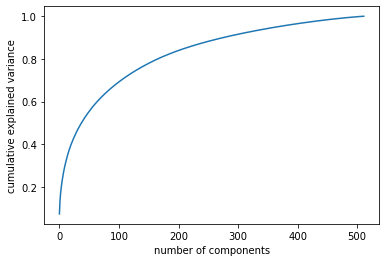

In [8]:
# juiste PCA componentes zoeken van de grafiek
pca = PCA()
data_reduced = pca.fit_transform(train_images_hogs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
# we namen als n_components 350
pca = PCA(n_components = 350)
# de getransformeerde data zijn onze features
x_train = pca.fit_transform(train_images_hogs)
x_test = pca.transform(test_images_hogs)


y_train = (df_train['general rating'] ).values
y_test = (df_test['general rating'] ).values

### First model

For the first model of this case we used linear regression, this is a good model to start with. You can see our first model scores pretty good, the mean squared error is low. But when we look closer at our predictions we can see that the model choses to stay around a score of 4/5. The model stays conservative with giving very low/high scores. 

These 2 representations are not enough to tell if the model is good/bad. because of this we wrote a functions to show us the pictures of the best/worst restaurants and the pictures of the best or worst predictions. This will show us what scores good and bad on the model.

mean squared error: 0.30356740841549573


<function matplotlib.pyplot.show(close=None, block=None)>

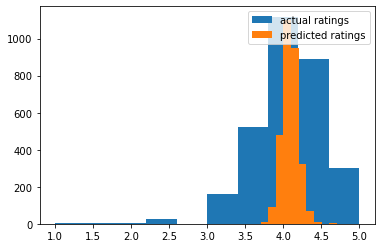

In [10]:
lr = LinearRegression()

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

print("mean squared error:",mean_squared_error(y_test,predictions))

plt.hist(y_test,label='actual ratings')
plt.hist(predictions , label='predicted ratings')
plt.legend(loc='upper right')
plt.show

2 Function to show the N worst/best photo's based on a certain column.

In [11]:
def show_top_photos(df, n, column_name):
    top = df.sort_values(by=[column_name]).head(n)

    fig, axs = plt.subplots(int(n/10), 10, figsize=(20,20))
    axs = axs.flatten()

    for i,ax in  enumerate(axs):
        img = top.iloc[i]['pixels']
        ax.imshow(img.reshape((128,128,3)))
        ax.set_axis_off()
        
    plt.subplots_adjust(top = n/100, bottom=0, hspace=0, wspace=0.1)
    plt.show()
        
def show_worst_photos(df, n, column_name):
    top = df.sort_values(by=[column_name]).tail(n)

    fig, axs = plt.subplots(int(n/10), 10, figsize=(20,20))
    axs = axs.flatten()

    for i,ax in  enumerate(axs):
        img = top.iloc[i]['pixels']
        ax.imshow(img.reshape((128,128,3)))
        ax.set_axis_off()
        
    plt.subplots_adjust(top = n/100, bottom=0, hspace=0, wspace=0.1)
    plt.show()

Below we can find 3 visualizations, each of them has 2 top rows that show 20 pictures of the best/worst restaurants. the bottom 2 rows are 20 of the best/worst pictures according to the prediction. The visualization can be handy to show what to model is looking for and it can be another metric to indicate how well the model performs.

The first visualization is of the pictures of the best restaurants and the pictures that received the highest rating by the model. We see some similarities between the top and bottom rows. But we noticed that the pictures of the prediction look a lot better than the pictures of the actual ratings. This might be due to the possibility that some restaurants have high ratings but low amounts of ratings. In case it is easy to manipulate the ratings for example friends, family, or the owner himself can rate the restaurant to appear good.

The second visualization addresses this problem, by first filtering based on the number of ratings. Only pictures of restaurants with more than 25 ratings are shown. From that selection, we take the top 100 and sample randomly 20 pictures. The reason for the sampling is that this way we get pictures of different restaurants. Otherwise, only pictures of the top 2-3 restaurants are shown. In the second visualization, we see a lot of similarities between the top 2 rows and the bottom 2 rows.

The third visualization is of the pictures of the worst restaurants and the pictures that received the lowest rating by the model. Here we don't see a lot of similarities, but we noticed that the pictures that score badly on the model look significantly worse than the pictures of predictions from the first and second visualization.

pictures of restaurants with the best ratings:


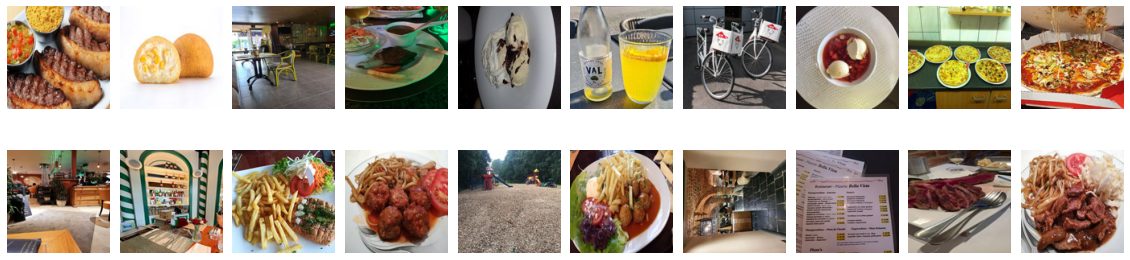

pictures with the best prediction:


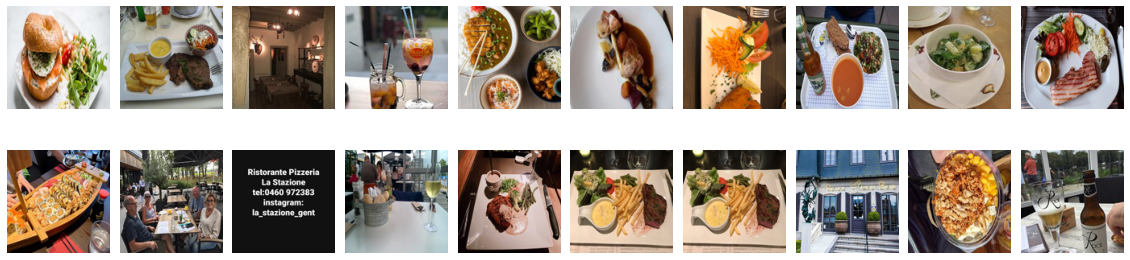

In [28]:
df_test['predictions'] = predictions.tolist()

print("pictures of restaurants with the best ratings:")
show_top_photos(df_test, 20 ,'general rating')

print("pictures with the best prediction:")
show_top_photos(df_test, 20 ,'predictions')

pictures of restaurants with the best ratings:


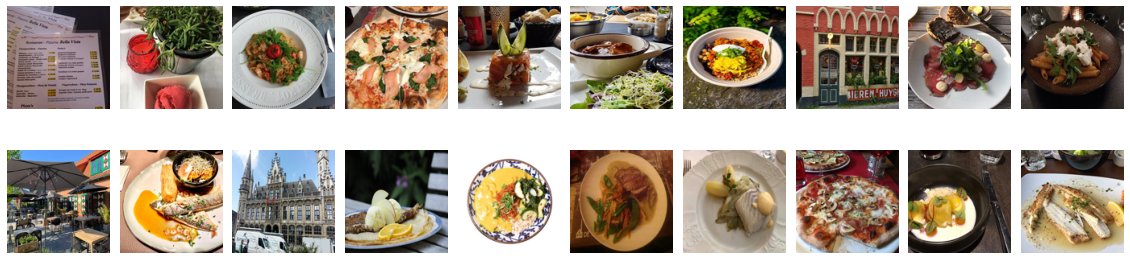

pictures with the best prediction:


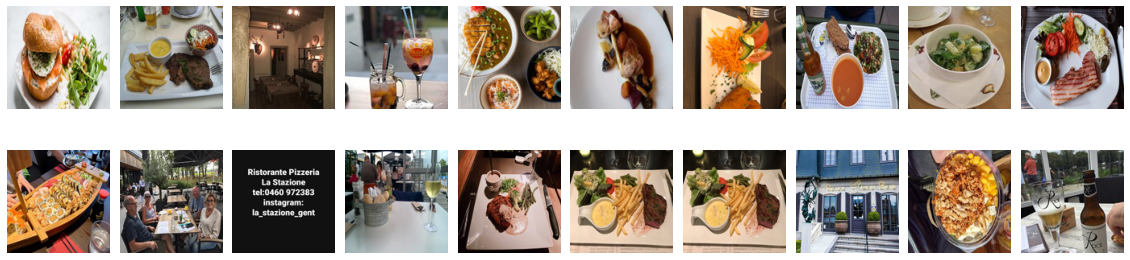

In [30]:
print("pictures of restaurants with the best ratings:")
show_top_photos(df_test.loc[df_test['number of reviews'] > 50].head(100).sample(n = 20), 20 ,'general rating')

print("pictures with the best prediction:")
show_top_photos(df_test,  20,'predictions')

pictures of restaurants with the worst ratings:


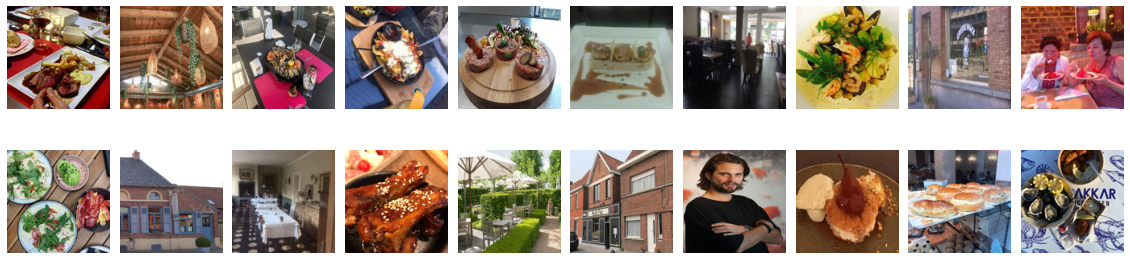

pictures with the worst prediction:


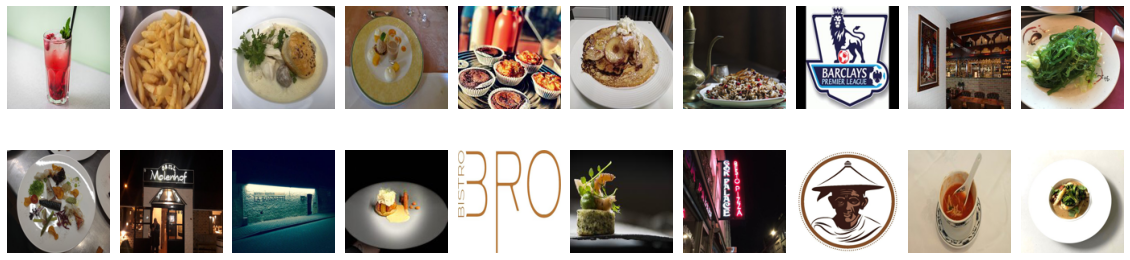

In [34]:
print("pictures of restaurants with the worst ratings:")
show_worst_photos(df_test.loc[df_test['number of reviews'] > 5].tail(50).sample(n = 20), 20 ,'general rating')

print("pictures with the worst prediction:")
show_worst_photos(df_test,  20,'predictions')

#### Conclusion of the first model

We conclude that the model is able to select predict how good a picture is. We can see that  pictures that score low look worse than the high scoring pictures. Pictures that score low often have a darker tint to them, it is also noticeble that pictures with alot of white in them score bad.

We can conclude out of this first model that mean squared error is not the best metric on how good the model performs. There is an easy explaniation for this: We assume that good restaurants have good pictures, but a good restaurant can still have some bad pictures, especially because some of the pictures are provided by customers.

### how can we improve the model

### Second model: adding width and height

In [ ]:
temp_train = pd.DataFrame(x_train)
temp_train['width'] = df_train.reset_index()['width']
temp_train['height'] = df_train.reset_index()['height']

temp_test = pd.DataFrame(x_test)
temp_test['width'] = df_test.reset_index()['width']
temp_test['height'] = df_test.reset_index()['height']

x_train = temp_train.values
x_test = temp_test.values

lr = LinearRegression()

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

print("mean squared error:",mean_squared_error(y_test,predictions))

print("pictures with the best prediction:")
show_top_photos(df_test,  20,'predictions')

print("pictures with the worst prediction:")
show_worst_photos(df_test,  20,'predictions')

### Third model: adding width and height as features

In [ ]:
x_train = temp_train.values
x_test = temp_test.values

lr = LinearRegression()

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

print("mean squared error:",mean_squared_error(y_test,predictions))

plt.hist(y_test,label='actual ratings')
plt.hist(predictions , label='predicted ratings')
plt.legend(loc='upper right')
plt.show

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x_train)

lr = LinearRegression()

lr.fit(x_poly, y_train)
predictions = lr.predict(poly_features.transform(x_test))

print(mean_squared_error(y_test,predictions)**(1/2))
print(r2_score(y_test,predictions))

In [ ]:
predictions = lr.predict(poly_features.transform(x_train))

print(mean_squared_error(y_train,predictions)**(1/2))

In [ ]:
# we namen als n_components 350
pca = PCA(n_components = 100)
# de getransformeerde data zijn onze features
x_train = pca.fit_transform(train_images_hogs)
x_test = pca.transform(test_images_hogs)


y_train = (df_train['general rating'] ).values
y_test = (df_test['general rating'] ).values

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x_train)

lr = LinearRegression()

lr.fit(x_poly, y_train)
predictions = lr.predict(poly_features.transform(x_test))


print("mean squared error:",mean_squared_error(y_test,predictions)**(1/2))

plt.hist(y_test,label='actual ratings')
plt.hist(predictions , label='predicted ratings')
plt.legend(loc='upper right')
plt.show

In [ ]:
overfitting? zeer hoge lage error of predition van train data maar zeer hoge error van prediction op test data

## Case 2

Creating a model that can predict the cuisine types of a restaurant based om the images that are available for that restaurant

### Setting up data

In [42]:
df = image_df
df['hog'] = df['pixels'].progress_apply(lambda x: hog_transformer(x,128,128))

df.head(1)

Pandas Apply:   0%|          | 0/15169 [00:00<?, ?it/s]

,restaurant_id,pixels,width,height,hog
0,7681907,"[253, 244, 238, 252, 243, 236, 252, 243, 234, ...",550,413,"[0.6850411260958398, 0.056635779259882106, 0.1..."


### How

To create a model that can do this, we will have to create a classification model. Since there are multiple cuisine types available, we will be using multiclass classification

We will be comparing different machine learning models and how good they perform.

In Sprint 1 we discovered that the tags column sometimes holds cuisine types that are not listed in the cuisines column, but because this were only a few cuisines, and none of them appeared more than 5 times, we don't need to add these to our dataframe. This is the case beacause with only so few data to learn from, it is not possible to train a good ML model. 

In [49]:
from sklearn.decomposition import PCA

# first, we need to create a dataframe that contains the id of a restaurant and one of the cuisines on each row
df_with_cuisines = sprint1_df[['id', 'cuisines']]
df_with_cuisines['cuisines'] = df_with_cuisines['cuisines'].apply(lambda x: str(x).split(','))
df_with_cuisines['all_cuisines'] = df_with_cuisines['cuisines'].apply(lambda x: [item.strip() for item in x])
df_with_cuisines = df_with_cuisines.explode('cuisines', ignore_index=True)
df_with_cuisines = pd.merge(df_with_cuisines, df.rename(columns={ 'restaurant_id' : 'id'}), on="id")
df_with_cuisines['cuisines'].apply(lambda x: x.strip())
df_with_cuisines['cuisine'] = df_with_cuisines['cuisines'].apply(lambda x: x.strip())
cuisine_counts = dict(df_with_cuisines['cuisine'].value_counts())

# we only keep the cuisines that occur more than 100 times, to be able to train a descent model on them
# a google search learned us that 100 is a good number to start with
cuisines_subset = { key: value for (key,value) in cuisine_counts.items() if value > 100 }

# now we replace all values that are not in the cuisines_subset with 'other'
df_with_cuisines['cuisine'] = df_with_cuisines['cuisine'].apply(lambda x: x if x in cuisines_subset else 'Other')

print("Value counts: \n") 
print(df_with_cuisines['cuisine'].value_counts())

print('\nDifferent amount of cuisines: ', len(df_with_cuisines['cuisine'].value_counts()))
df_with_cuisines.head()

Value counts: 

European            10716
Belgian              9276
French               2419
Dutch                1870
Seafood              1773
Italian              1520
Other                1405
Asian                1125
Mediterranean         993
Bar                   806
Pub                   803
Healthy               688
nan                   684
Contemporary          680
Pizza                 676
Cafe                  638
International         594
Grill                 484
Japanese              424
Chinese               374
Thai                  360
Sushi                 357
Fast Food             339
Fusion                329
Spanish               270
Diner                 250
Turkish               241
Greek                 208
American              207
Steakhouse            202
Wine Bar              200
Central European      192
Barbecue              183
Indian                173
Gastropub             167
Middle Eastern        160
Soups                 156
Street Food           

/var/folders/hy/djl88vtd4sxfh9lxbfyxdfsm0000gn/T/ipykernel_7138/3740999022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_cuisines['cuisines'] = df_with_cuisines['cuisines'].apply(lambda x: str(x).split(','))
/var/folders/hy/djl88vtd4sxfh9lxbfyxdfsm0000gn/T/ipykernel_7138/3740999022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_cuisines['all_cuisines'] = df_with_cuisines['cuisines'].apply(lambda x: [item.strip() for item in x])


,id,cuisines,all_cuisines,pixels,width,height,hog,cuisine
0,13969825,Thai,"[Thai, Healthy]","[135, 93, 45, 125, 84, 42, 158, 118, 67, 176, ...",450,450,"[0.35355339053803103, 0.35355339053803103, 0.3...",Thai
1,13969825,Thai,"[Thai, Healthy]","[96, 67, 37, 90, 63, 33, 74, 48, 21, 78, 53, 2...",450,450,"[0.4457560097742511, 0.20121010236536493, 0.15...",Thai
2,13969825,Thai,"[Thai, Healthy]","[37, 34, 28, 42, 36, 22, 65, 50, 18, 85, 63, 9...",450,450,"[0.22099164477593786, 0.04157802340082818, 0.0...",Thai
3,13969825,Thai,"[Thai, Healthy]","[234, 223, 203, 169, 158, 138, 168, 157, 137, ...",150,150,"[0.35355339053803103, 0.35355339053803103, 0.3...",Thai
4,13969825,Thai,"[Thai, Healthy]","[56, 46, 36, 54, 44, 34, 52, 42, 32, 52, 42, 3...",450,450,"[0.5088335392552413, 0.05806857826722176, 0.06...",Thai


The data has to be standardized before we can train our models.

In [50]:
scaler_hog = StandardScaler()
hogs_scaled = scaler_hog.fit_transform(df_with_cuisines['hog'].to_list())

We are working with a lot of images, so to further decrease the dimensionality of the data, we will use PCA. As we have already shown in Case 1, we will use 350 components.

In [51]:
pca = PCA(n_components=350)
hogs_scaled_reduced = pca.fit_transform(hogs_scaled)

We will now split the data in train and test data, with input and output data.
- The input are the hogs that are scaled and reduces trough PCA.
- The output data are the cuisine types.

In [52]:
# set output data to numeric values
output_data = pd.DataFrame()
output_data['category'] = df_with_cuisines['cuisine'].astype('category').cat.codes.values
output_data['all categories'] = df_with_cuisines['all_cuisines']


# Create DataFrame to map cuisines to numeric values
cuisines_mapped = pd.DataFrame()
cuisines_mapped['cuisine'] = df_with_cuisines['cuisine']
cuisines_mapped['cuisine_id'] = output_data['category']
cuisines_mapped.drop_duplicates(inplace=True)
cuisines_mapped.sort_values(by='cuisine_id')

x2_train, x2_test, y2_train, y2_test = train_test_split(hogs_scaled_reduced, output_data, test_size=0.2, random_state=0)

### Comparing the different models
Now, we will be comparing the different models. 
We will be training 4 different models:
- Logistic regression model
  - "One vs All" model
- Softmax regression model
- SVM model using a "One vs One" approach
- SVM model using a "One vs The Rest" approach

#### Creating and Training the Logistic Regression model

In [58]:
one_vs_all_model = LogisticRegression(multi_class='ovr', solver='liblinear')
one_vs_all_model.fit(x2_train, y2_train['category'])

LogisticRegression(multi_class='ovr', solver='liblinear')

#### Creating and Training the Softmax regression model

In [ ]:
softmax_regression_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
softmax_regression_model.fit(x2_train, y2_train['category'])

#### Creating and Training the SVM model using a "One vs One" approach

In [ ]:
svm_one_vs_one_model = svm.SVC(decision_function_shape='ovo')
svm_one_vs_one_model.fit(x2_train, y2_train['category'])#### Creating and Training the SVM model using a "One vs The Rest" approach

#### Creating and Training the SVM model using a "One vs The Rest" approach

In [ ]:
svm_one_vs_the_rest_model = svm.SVC(decision_function_shape='ovr', max_iter=10000)
svm_one_vs_the_rest_model.fit(x2_train, y2_train['category'])

### Use models to predict cuisine value

In [ ]:
predictions_one_vs_all = one_vs_all_model.predict(x2_test)
predictions_softmax = softmax_regression_model.predict(x2_test)
predictions_svm_one_vs_one = svm_one_vs_one_model.predict(x2_test)
predictions_svm_one_vs_the_rest = svm_one_vs_the_rest_model.predict(x2_test)

We will now add all of the predictions of the different models, and change the numeric values of the cuisine types back to the textual values. 

In [ ]:
predictions_df = pd.DataFrame()
predictions_df['one_vs_all_prediction'] = predictions_one_vs_all
predictions_df['softmax_prediction'] = predictions_softmax
predictions_df['svm_one_vs_one_prediction'] = predictions_svm_one_vs_one
predictions_df['svm_one_vs_the_rest_prediction'] = predictions_svm_one_vs_the_rest


predictions_df['one_vs_all_prediction'] = predictions_df['one_vs_all_prediction'].apply(lambda x: cuisines_mapped[cuisines_mapped['cuisine_id'] == x]['cuisine'].values[0])
predictions_df['softmax_prediction'] = predictions_df['softmax_prediction'].apply(lambda x: cuisines_mapped[cuisines_mapped['cuisine_id'] == x]['cuisine'].values[0])
predictions_df['svm_one_vs_one_prediction'] = predictions_df['svm_one_vs_one_prediction'].apply(lambda x: cuisines_mapped[cuisines_mapped['cuisine_id'] == x]['cuisine'].values[0])
predictions_df['svm_one_vs_the_rest_prediction'] = predictions_df['svm_one_vs_the_rest_prediction'].apply(lambda x: cuisines_mapped[cuisines_mapped['cuisine_id'] == x]['cuisine'].values[0])

Now that we have all the predicted cuisine values for each cuisine type, we can check if the value is a part of all cuisines that we accept as correct. For example: if a picture is taken in a restaurant that has cuisine types European and Belgian, we will accept the prediction of the model as correct if the prediction is one of those cuisine types.

In [ ]:
predictions_df['all_cuisines'] = y2_test['all categories'].values
predictions_df['one_vs_all_correct'] = predictions_df.apply(lambda x: 1 if x['one_vs_all_prediction'].strip() in x['all_cuisines'] else 0, axis=1)
predictions_df['softmax_prediction_correct'] = predictions_df.apply(lambda x: 1 if x['softmax_prediction'].strip()  in x['all_cuisines'] else 0, axis=1)
predictions_df['svm_one_vs_one_prediction_correct'] = predictions_df.apply(lambda x: 1 if x['svm_one_vs_one_prediction'].strip()  in x['all_cuisines'] else 0, axis=1)
predictions_df['svm_one_vs_the_rest_prediction_correct'] = predictions_df.apply(lambda x: 1 if x['svm_one_vs_the_rest_prediction'].strip()  in x['all_cuisines'] else 0, axis=1)

If we take the average value of each of the columns that tells if our model made a correct prediction or not, we can get the accuracy of each model. We will show the accuracy in  

In [ ]:
accuracies = {'Logistic regression': predictions_df['one_vs_all_correct'].mean(), 
              'Softmax regression': predictions_df['softmax_prediction_correct'].mean(),
              'SVM (One versus One)': predictions_df['svm_one_vs_one_prediction_correct'].mean(),
              'SVM (One versus The Rest)': predictions_df['svm_one_vs_the_rest_prediction_correct'].mean()}


pd.Series(accuracies).sort_values().plot(kind='barh', figsize=(10,2), title='Accuracy of different models')